# Training a neural network in Tensorflow

This notebook demonstrates training a classifier in Tensorflow, which should mirror what has been done in the scikit-learn notebooks. This is based on the training scripts and the Neural Network architecture they contained, created by Cyril Morecrettte.

In [1]:
import pathlib
import os
import datetime
import math
import functools
import numpy

In [2]:
import pandas

In [3]:
import iris

In [4]:
import matplotlib

In [5]:
%matplotlib inline

In [6]:
import sklearn
import sklearn.preprocessing
import sklearn.metrics

In [7]:
import tensorflow

import tensorflow.keras
import tensorflow.keras.layers
import tensorflow.keras.models
import tensorflow.keras.optimizers
import tensorflow.keras.metrics
import tensorflow.keras.layers
import tensorflow.keras.constraints

In [8]:
try:
    root_data_dir = pathlib.Path(os.environ['OPMET_DATA_ROOT'])
except KeyError:
    root_data_dir = pathlib.Path('/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge')
root_data_dir  

PosixPath('/Users/stephen.haddad/data/ml_challenges')

In [9]:
try:
    project_output_dir = pathlib.Path(os.environ['OPMET_OUTPUT'])
except KeyError:
    project_output_dir = pathlib.Path().absolute()
project_output_dir

PosixPath('/Users/stephen.haddad/prog/data_science_cop/challenges')

## Loading Falklands Rotor Data

In [10]:
root_data_dir.joinpath('Rotors')

PosixPath('/Users/stephen.haddad/data/ml_challenges/Rotors')

In [11]:
falklands_dir = 'Rotors'
falklands_data_path = root_data_dir.joinpath(falklands_dir)
falklands_data_path

PosixPath('/Users/stephen.haddad/data/ml_challenges/Rotors')

In [12]:
falklands_new_training_data_path = falklands_data_path.joinpath( 'new_training.csv')
falklands_new_training_data_path

PosixPath('/Users/stephen.haddad/data/ml_challenges/Rotors/new_training.csv')

In [13]:
falklands_training_df = pandas.read_csv(falklands_new_training_data_path, header=0).loc[1:,:]
falklands_training_df

,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,Rotors 1 is true
1,01/01/2015 00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,282.625,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,NaN
2,01/01/2015 03:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,280.250,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,NaN
3,01/01/2015 06:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,278.625,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,NaN
4,01/01/2015 09:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,278.250,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,NaN
5,01/01/2015 12:00,279.9,277.4,120.0,8.7,-9999999.0,279.250,278.875,278.375,277.875,...,1.6,273.0,2.0,303.0,2.3,329.0,2.5,338.0,2.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,31/12/2020 06:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,277.500,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,NaN
20102,31/12/2020 09:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,NaN
20103,31/12/2020 12:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,279.625,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,NaN
20104,31/12/2020 15:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,283.000,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,NaN


In [14]:
falklands_training_df = falklands_training_df.drop_duplicates(subset='DTG')

In [15]:
falklands_training_df.shape

(17507, 95)

## Preprocess data for training

### Specify and create input features

In [16]:
temp_feature_names = [f'air_temp_{i1}' for i1 in range(1,23)]
humidity_feature_names = [f'sh_{i1}' for i1 in range(1,23)]
wind_direction_feature_names = [f'winddir_{i1}' for i1 in range(1,23)]
wind_speed_feature_names = [f'windspd_{i1}' for i1 in range(1,23)]
target_feature_name = 'rotors_present'

In [17]:
def get_v_wind(wind_dir_name, wind_speed_name, row1):
    return math.cos(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

def get_u_wind(wind_dir_name, wind_speed_name, row1):
    return math.sin(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

In [ ]:
u_feature_template = 'u_wind_{level_ix}'
v_feature_template = 'v_wind_{level_ix}'
u_wind_feature_names = []
v_wind_features_names = []
for wsn1, wdn1 in zip(wind_speed_feature_names, wind_direction_feature_names):
    level_ix = int( wsn1.split('_')[1])
    u_feature = u_feature_template.format(level_ix=level_ix)
    u_wind_feature_names += [u_feature]
    falklands_training_df[u_feature_template.format(level_ix=level_ix)] = falklands_training_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
    v_feature = v_feature_template.format(level_ix=level_ix)
    v_wind_features_names += [v_feature]
    falklands_training_df[v_feature_template.format(level_ix=level_ix)] = falklands_training_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

In [ ]:
falklands_training_df[target_feature_name] =  falklands_training_df['Rotors 1 is true']
falklands_training_df.loc[falklands_training_df[falklands_training_df['Rotors 1 is true'].isna()].index, target_feature_name] = 0.0
falklands_training_df[target_feature_name]  = falklands_training_df[target_feature_name] .astype(bool)

In [ ]:
falklands_training_df[target_feature_name].value_counts()

In [ ]:
falklands_training_df.columns

### Split into traing/validate/test sets

In [ ]:
test_fraction = 0.1
validation_fraction = 0.1

In [ ]:
num_no_rotors = sum(falklands_training_df[target_feature_name] == False)
num_with_rotors = sum(falklands_training_df[target_feature_name] == True)

In [24]:
data_no_rotors = falklands_training_df[falklands_training_df[target_feature_name] == False]
data_with_rotors = falklands_training_df[falklands_training_df[target_feature_name] == True]

In [25]:
data_test = pandas.concat([data_no_rotors.sample(int(test_fraction * num_no_rotors)), data_with_rotors.sample(int(test_fraction * num_with_rotors))])
data_test[target_feature_name].value_counts()

False    1705
True       44
Name: rotors_present, dtype: int64

In [26]:
falklands_training_df['test_set'] = False
falklands_training_df.loc[data_test.index,'test_set'] = True

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14930/1871749377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df['test_set'] = False


In [27]:
data_working = falklands_training_df[falklands_training_df['test_set'] == False]
data_working_no_rotors = data_working[data_working[target_feature_name] == False]
data_working_with_rotors = data_working[data_working[target_feature_name] == True]

In [28]:
data_validation = pandas.concat(
    [data_working_no_rotors.sample(int(validation_fraction * num_no_rotors)), 
     data_working_with_rotors.sample(int(validation_fraction * num_with_rotors))])
falklands_training_df['validation_set'] = False
falklands_training_df.loc[data_validation.index,'validation_set'] = True

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_14930/2574544301.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  falklands_training_df['validation_set'] = False


In [29]:
data_validation[target_feature_name].value_counts()

False    1705
True       44
Name: rotors_present, dtype: int64

In [30]:
data_train = falklands_training_df[(~falklands_training_df['test_set']) & (~falklands_training_df['validation_set'])]

In [31]:
data_train[target_feature_name].value_counts()

False    13648
True       361
Name: rotors_present, dtype: int64

# Preprocess data into input for ML algorithm

In [32]:
input_feature_names = temp_feature_names + humidity_feature_names + u_wind_feature_names + v_wind_features_names

In [33]:
preproc_dict = {}
for if1 in input_feature_names:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(data_train[[if1]])
    preproc_dict[if1] = scaler1

In [34]:
target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(data_train[[target_feature_name]])

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-tf/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LabelEncoder()

Apply transformation to each input column

In [35]:
def preproc_input(data_subset, pp_dict):
    return numpy.concatenate([scaler1.transform(data_subset[[if1]]) for if1,scaler1 in pp_dict.items()],axis=1)

def preproc_target(data_subset, enc1):
     return enc1.transform(data_subset[[target_feature_name]])

In [36]:
preproc_target(data_train, target_encoder).reshape((-1,1)).shape

(14009, 1)

In [37]:
preproc_dict['air_temp_1'].transform(data_train[['air_temp_1']]).shape

(14009, 1)

In [38]:
X_train = preproc_input(data_train, preproc_dict)
y_train = numpy.concatenate(
    [preproc_target(data_train, target_encoder).reshape((-1,1)),
    1.0 - (preproc_target(data_train, target_encoder).reshape((-1,1))),],
    axis=1
)

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-tf/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


create target feature from rotors

In [39]:
y_train.shape, X_train.shape

((14009, 2), (14009, 88))

In [40]:
X_val = preproc_input(data_validation, preproc_dict)
y_val = numpy.concatenate(
    [preproc_target(data_validation, target_encoder).reshape((-1,1)),
    1.0 - (preproc_target(data_validation, target_encoder).reshape((-1,1))),],
    axis=1
)

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-tf/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [41]:
X_test = preproc_input(data_test, preproc_dict)
y_test = numpy.concatenate(
    [preproc_target(data_test, target_encoder).reshape((-1,1)),
    1.0 - (preproc_target(data_test, target_encoder).reshape((-1,1))),],
    axis=1
)

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-tf/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [42]:
train_val_test_tuples = [
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),    
]

## Train classifiers

### Train Nerual Network using Tensorflow Keras

In [43]:
initial_learning_rate=1.0e-4
drop_out_rate=0.2
n_epochs=200
batch_size=1000

In [44]:
n_nodes = 300
n_layers = 4
nx = X_train.shape[1]

In [45]:
model = tensorflow.keras.models.Sequential()
model.add(tensorflow.keras.layers.Dropout(drop_out_rate, input_shape=(nx,)))
for i in numpy.arange(0,n_layers):
    model.add(tensorflow.keras.layers.Dense(n_nodes, activation='relu', kernel_constraint=tensorflow.keras.constraints.max_norm(3)))
    model.add(tensorflow.keras.layers.Dropout(drop_out_rate))
model.add(tensorflow.keras.layers.Dense(2, activation='softmax'))             # This is the output layer 
model.summary()


2021-10-12 13:50:32.704988: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 88)                0         
_________________________________________________________________
dense (Dense)                (None, 300)               26700     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0

In [46]:
opt = tensorflow.optimizers.Adam(learning_rate=initial_learning_rate)  

In [47]:
model.compile(optimizer=opt, loss='mse', metrics=[tensorflow.keras.metrics.RootMeanSquaredError()])

In [48]:
# Write things out to file (for reading back in later to make predictions).
#TODO: write this out in ONNX
model_json=model.to_json()
model_out_fname = 'rotors_tf_model.json'
model_output_path = project_output_dir.joinpath(model_out_fname)
with open(model_output_path, "w") as json_file:
    json_file.write(model_json)

In [49]:
%time 
history=model.fit(X_train, 
                  y_train, 
                  validation_data=(X_val, 
                                   y_val), 
                  epochs=n_epochs, 
                  batch_size=batch_size, 
                  shuffle=True,
                  verbose=0,
                 )

2021-10-12 13:50:32.865848: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


In [50]:
y_train_pred_raw = model.predict(X_train)[:,0]
y_val_pred_raw = model.predict(X_val)[:,0]
y_test_pred_raw = model.predict(X_test)[:,0]

In [51]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [52]:
def calc_sedi(conf_mat):
    hr1 = conf_mat[1,1] / (conf_mat[1,0] + conf_mat[1,1])
    fa1 = conf_mat[0,1] / (conf_mat[0,0] + conf_mat[0,1])
    sedi_score1 = (
        (numpy.log(fa1) - numpy.log(hr1) - numpy.log(1.0-fa1) + numpy.log(1.0-hr1) )
        / (numpy.log(fa1) + numpy.log(hr1) + numpy.log(1.0 - fa1) + numpy.log(1.0-hr1) )  )
    return sedi_score1

In [53]:
thresholds_list = list(numpy.arange(1e-3,0.3,1e-3))
hit_rates = []
hit_rates_test = []
false_alarm_rates = []
false_alarm_rates_test = []
sedi_list = []
sedi_list_test = []
for threshold in numpy.arange(1e-3,0.3,1e-3):
    y_pred_train = list(map(float, y_train_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_train[:,0], y_pred_train)
    hit_rates += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list += [calc_sedi(cm1)]

    y_pred_test = list(map(float, y_test_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_test[:,0], y_pred_test)
    hit_rates_test += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates_test += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list_test += [calc_sedi(cm1)]

    

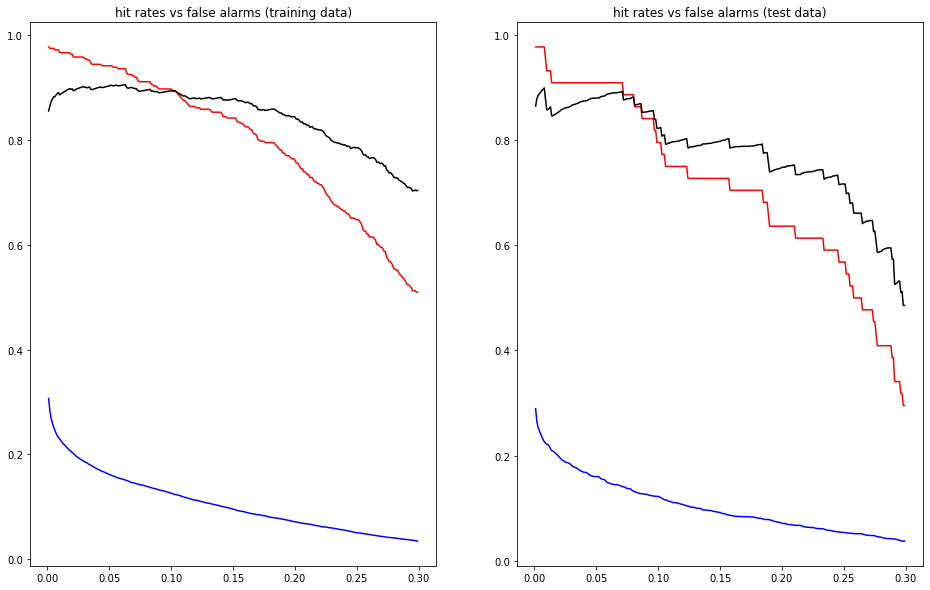

In [54]:
f1 = matplotlib.pyplot.figure(figsize=(16,10))
ax1 = f1.add_subplot(1,2,1,title='hit rates vs false alarms (training data)')
ax1.plot(thresholds_list, hit_rates,'r')
ax1.plot(thresholds_list, false_alarm_rates,'b')
ax1.plot(thresholds_list, sedi_list,'k')

ax1 = f1.add_subplot(1,2,2,title='hit rates vs false alarms (test data)')
ax1.plot(thresholds_list, hit_rates_test,'r')
ax1.plot(thresholds_list, false_alarm_rates_test,'b')
ax1.plot(thresholds_list, sedi_list_test,'k')



In [55]:
y_train.shape[0],( y_train==0).sum(), (model.predict(X_train)==0).sum()

(14009, 14009, 0)

### Resample the data 

Our yes/no classes for classification are very unbalanced, so we can try doing a naive resampling so we have equal representation fo the two classes in our sample set.

In [56]:
data_train_resampled = pandas.concat([
    data_train[data_train[target_feature_name] == True].sample(n=int(1e4), replace=True), 
    data_train[data_train[target_feature_name] == False].sample(n=int(1e4), replace=False),],
    ignore_index=True)

In [57]:
X_train_resampled = preproc_input(data_train_resampled, preproc_dict)
y_train_resampled = numpy.concatenate(
    [preproc_target(data_train_resampled, target_encoder).reshape((-1,1)),
    1.0 - (preproc_target(data_train_resampled, target_encoder).reshape((-1,1))),],
    axis=1
)

/Users/stephen.haddad/opt/anaconda3/envs/data-science-cop-tf/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [58]:
train_val_test_res_tuples = [
    (X_train_resampled, y_train_resampled),
    (X_val, y_val),
    (X_test, y_test),    
]

In [59]:
model_res = tensorflow.keras.models.Sequential()
model_res.add(tensorflow.keras.layers.Dropout(drop_out_rate, input_shape=(nx,)))
for i in numpy.arange(0,n_layers):
    model_res.add(tensorflow.keras.layers.Dense(n_nodes, 
                                                activation='relu', 
                                                kernel_constraint=tensorflow.keras.constraints.max_norm(3)))
    model_res.add(tensorflow.keras.layers.Dropout(drop_out_rate))
model_res.add(tensorflow.keras.layers.Dense(2, activation='softmax'))             # This is the output layer 
model_res.summary()
opt_res = tensorflow.optimizers.Adam(learning_rate=initial_learning_rate)  
model_res.compile(optimizer=opt_res, 
                  loss='mse',
                  metrics=[tensorflow.keras.metrics.RootMeanSquaredError()])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_5 (Dropout)          (None, 88)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               26700     
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_7 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_8 (Dropout)          (None, 300)              

In [60]:
%time 
history_res = model_res.fit(
    X_train_resampled,
    y_train_resampled,
    validation_data=(X_val, 
                     y_val), 
    epochs=n_epochs, 
    batch_size=batch_size, 
    shuffle=True,
    verbose=0,
)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [61]:
y_train_res_pred_raw = model_res.predict(X_train_resampled)[:,0]
y_val_res_pred_raw = model_res.predict(X_val)[:,0]
y_test_res_pred_raw = model_res.predict(X_test)[:,0]

In [62]:
hit_rates_res = []
false_alarm_rates_res = []
sedi_list_res = []
for threshold in numpy.arange(1e-3,0.3,1e-3):
    y_pred_train = list(map(float, y_train_res_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_train_resampled[:,0], y_pred_train)
    hit_rates_res += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates_res += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list_res += [calc_sedi(cm1)]
    
    

In [63]:
hit_rates_res = []
hit_rates_res_test = []
false_alarm_rates_res = []
false_alarm_rates_res_test = []
sedi_list_res = []
sedi_list_res_test = []
for threshold in numpy.arange(1e-3,0.3,1e-3):
    y_pred_train = list(map(float, y_train_res_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_train_resampled[:,0], y_pred_train)
    hit_rates_res += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates_res += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list_res += [calc_sedi(cm1)]
    
    y_pred_test = list(map(float, y_test_res_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_test[:,0], y_pred_test)
    hit_rates_res_test += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates_res_test += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list_res_test += [calc_sedi(cm1)]


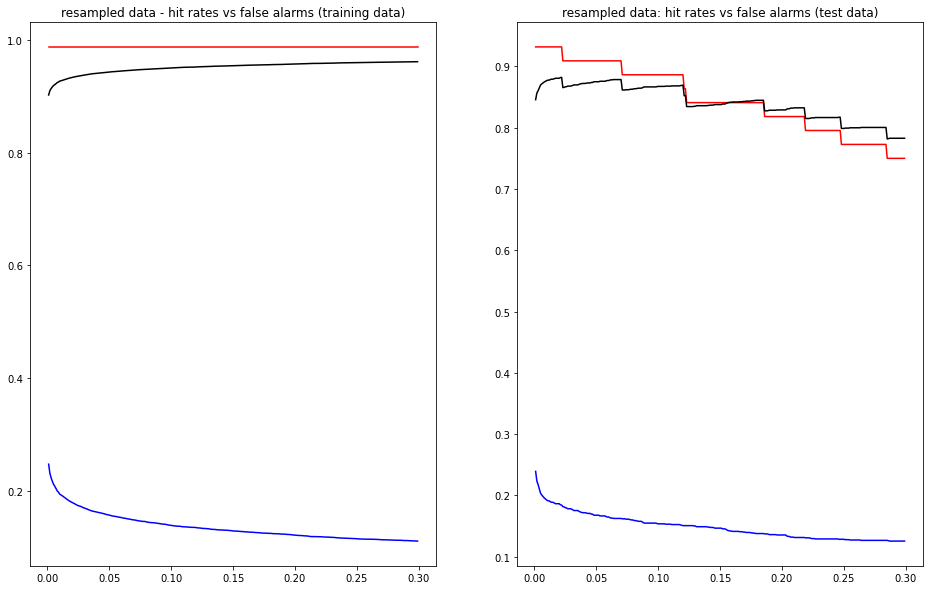

In [64]:
f1 = matplotlib.pyplot.figure('res_train_metrics', figsize=(16,10))
ax1 = f1.add_subplot(1,2,1,title='resampled data - hit rates vs false alarms (training data)')
ax1.plot(thresholds_list, hit_rates_res,'r')
ax1.plot(thresholds_list, false_alarm_rates_res,'b')
ax1.plot(thresholds_list, sedi_list_res,'k')

ax1 = f1.add_subplot(1,2,2,title='resampled data: hit rates vs false alarms (test data)')
ax1.plot(thresholds_list, hit_rates_res_test,'r')
ax1.plot(thresholds_list, false_alarm_rates_res_test,'b')
ax1.plot(thresholds_list, sedi_list_res_test,'k')
